# Import dependencies

## Dear reader, if you are reading this as words flow from the page into your brain, from one electric impulse to another, I want you to know I spent 4 days on this program. What does it do? The same as the other that I built in 15 minutes. Why did I choose to make another one? Because I thought it would be fancier. Do not do the same mistakes in your life. If it works, keep it simple. With love, someone not so dumb anymore.

***P.S If there is not enough documentation, I am sorry :( . It is 2 AM, and I am not spending one more day on this***


In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import datetime

start_time = datetime.datetime.now()

2024-04-03 00:55:05.112025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 00:55:06.300100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!nvidia-smi

Wed Apr  3 00:55:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:2D:00.0  On |                  N/A |
| 30%   44C    P8             N/A /  115W |    6453MiB /   8188MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import data from train
# Separate it into images of (48,48) and labels

In [3]:
sign_names = ["limit_zone_20","limit_zone_30","limit_zone_50","limit_zone_60","limit_zone_70",
              "limit_zone_80","end_of_speed_limit","limit_zone_100","limit_zone_120",
              "no_passing","no_passing_for_trucks","right_of_way","priority_road",
              "yield_right_of_way","stop","prohibited_for_all_vehicles","tractors_and_trucks_prohibited",
              "entry_prohibited","danger","single_curve_left","single_curve_right","double_curve",
              "rough_road","slippery_road","road_narrows","construction_site","signal_lights_ahead","pedestrian_crosswalk_ahead",
              "children","bicycle_crossing","snow_ahead","wild_animal_crossing","end_of_all_restrictions",
               "mandatory_right","mandatory_left","mandatory_ahead","mandatory_ahead_right",
              "mandatory_ahead_left","mandatory_down_right","mandatory_down_left","traffic_circle","end_of_no_passing_zone",
              "end_of_no_passing_zone_trucks"]

In [4]:
def get_dataset(directory,type_of_data="train",IMAGE_SIZE=(48,48),num_classes=43):
    X = []
    y = []
    for i in range(num_classes):
        path = os.path.join(directory,type_of_data,str(i))
        for j in os.listdir(path):
            image = Image.open(path + '/'+ j)
            image = image.resize(IMAGE_SIZE)
            image = np.array(image)
            X.append(image)
            y.append(i)
            
    train_data = np.array(X)
    train_labels = np.array(y)
    
    # Split the data into training/validation
    x_train, x_valid, y_train, y_valid = train_test_split(train_data, 
                                                    train_labels, 
                                                    test_size=0.2, 
                                                    random_state=42)
    
    # Encode the labels
    # Thus, every label hold information about which class the image is 
    # And also all the classes that it is not


    y_train = to_categorical(y_train, 43)
    y_valid = to_categorical(y_valid, 43)
    
    
    print(f"The shape of our training data: {x_train.shape}")
    print(f"The shape of our training labels: {y_train.shape}")
    print(f"The shape of our validation data: {x_valid.shape}")
    print(f"The shape of our validation images: {y_valid.shape}")
    print(f"One of our labels: {y_valid[0]}")
    
    # Create datasets for faster processing
    # In this way, we will be able to fetch data gradually into out model
    # Convert each type of data into a Dataset, and then zip them together

    train_dataset = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(x_train),
        tf.data.Dataset.from_tensor_slices(y_train)
    ))

    valid_dataset = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(x_valid),
        tf.data.Dataset.from_tensor_slices(y_valid)
    ))
    
    return train_dataset, valid_dataset


In [5]:
directory = "gtsrb_traffic_sign/"
IMAGE_SIZE = (96,96)
SMALL_IMAGE_SIZE = (48,48)
num_classes = 43

train_dataset, valid_dataset = get_dataset(directory=directory,
                                      type_of_data="train",
                                      IMAGE_SIZE=SMALL_IMAGE_SIZE,
                                      num_classes=num_classes)

train_dataset_histogram, valid_dataset_histogram = get_dataset(directory="gtsrb_traffic_sign_changed/")
train_dataset_adapt, valid_dataset_adapt = get_dataset(directory="gtsrb_traffic_sign_adapt_eq/")
train_dataset_normalize, valid_dataset_normalize = get_dataset(directory="gtsrb_traffic_sign_normalize/")


The shape of our training data: (31367, 48, 48, 3)
The shape of our training labels: (31367, 43)
The shape of our validation data: (7842, 48, 48, 3)
The shape of our validation images: (7842, 43)
One of our labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


2024-04-03 00:57:26.276051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 00:57:26.303896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 00:57:26.303967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 00:57:26.306788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 00:57:26.306867: I external/local_xla/xla/stream_executor

The shape of our training data: (31367, 48, 48)
The shape of our training labels: (31367, 43)
The shape of our validation data: (7842, 48, 48)
The shape of our validation images: (7842, 43)
One of our labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shape of our training data: (31367, 48, 48)
The shape of our training labels: (31367, 43)
The shape of our validation data: (7842, 48, 48)
The shape of our validation images: (7842, 43)
One of our labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The shape of our training data: (31367, 48, 48, 3)
The shape of our training labels: (31367, 43)
The shape of our validation data: (7842, 48, 48, 3)
The shape of our validation images: (7842, 43)
One of our labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.

# Create two datasets for faster processing of data

In [6]:


train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_histogram = train_dataset_histogram.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset_histogram = valid_dataset_histogram.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_adapt = train_dataset_adapt.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset_adapt = valid_dataset_adapt.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_normalize = train_dataset_normalize.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset_normalize = valid_dataset_normalize.batch(32).prefetch(tf.data.AUTOTUNE)

The reason we first import the data, split it, and the put it together in two datasets is because we want the images to be shuffled correctly and to keep their respective labels. We want to have examples of all classes for both training and validation. Further mode, we convert the data into tensorflow datasets. This allows us to prefetch elements (feed them gradually into the model, and thus reduce memory usage) and to normalize each image between [0.,1.] for easier processing.

# Define Callbacks for automatic tuning

In [7]:
# Create callbacks for our model
# Callbacks add functionality to our model while it is still running

# Define a callback for reducing learning rate on plateau
# This way, when the model gets to a point where it 'stucks', it can reduce lr to refine results
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',       # Quantity to monitor
    factor=0.1,               # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=4,               # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,              # Lower bound on the learning rate
    verbose=1                 # Verbosity level (0 or 1) 
)

# Stop the model if it is not progressing
# I arbitrarily set this callback to 2 x reduce_lr_callback patience 
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=6,

)


# Define a Functional CNN Model 

In [9]:
inputs = Input(shape=(48,48,3), name="input_layer")
random_flip = layers.RandomFlip("horizontal_and_vertical")(inputs)
random_rotation = layers.RandomRotation(0.2)(random_flip)
crop = layers.RandomCrop(48,48)(random_rotation)
rescale = layers.Rescaling(scale=1./255)(crop)
conv_1 = Conv2D(filters=64, kernel_size=5,activation="relu")(rescale)
conv_2 = Conv2D(filters=64, kernel_size=5,activation="relu")(conv_1)
max_pool_2 = MaxPool2D()(conv_2)
conv_3 = Conv2D(32, kernel_size=4,activation="relu")(max_pool_2)
conv_4 = Conv2D(filters=64, kernel_size=5,activation="relu")(conv_3)
max_pool_3 = MaxPool2D()(conv_3)
flat = Flatten()(max_pool_3)
dense_1 = Dense(256, activation="relu")(flat)
drop = Dropout(0.4)(dense_1)
outputs = Dense(num_classes, activation="softmax")(drop)
model = tf.keras.Model(inputs,outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 48, 48, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_crop_1 (RandomCrop)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 44, 44, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,723 (2.58 MB)

 Trainable params: 675,723 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=["accuracy","precision","recall"])

history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=valid_dataset,
                    callbacks=[reduce_lr_callback,early_stopping_callback])

Epoch 1/100


2024-04-03 01:04:29.488762: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.2296 - loss: 2.7274 - precision: 0.6647 - recall: 0.0863 - val_accuracy: 0.5635 - val_loss: 1.3112 - val_precision: 0.8859 - val_recall: 0.3358 - learning_rate: 0.0010
Epoch 2/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5785 - loss: 1.2717 - precision: 0.8038 - recall: 0.3967 - val_accuracy: 0.7373 - val_loss: 0.7941 - val_precision: 0.8499 - val_recall: 0.6088 - learning_rate: 0.0010
Epoch 3/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.7025 - loss: 0.8916 - precision: 0.8244 - recall: 0.5814 - val_accuracy: 0.7876 - val_loss: 0.6249 - val_precision: 0.8822 - val_recall: 0.6912 - learning_rate: 0.0010
Epoch 4/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.7604 - loss: 0.7128 - precision: 0.8471 - recall: 0.6735 - val_accuracy: 0.8308 - val_loss: 0.5176 - val_precision: 0.8792 - val_recall: 0.7919 - learning_rate: 0.0010
Epoch 5/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accurac

981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.9239 - loss: 0.2383 - precision: 0.9383 - recall: 0.9130 - val_accuracy: 0.9521 - val_loss: 0.1472 - val_precision: 0.9586 - val_recall: 0.9468 - learning_rate: 0.0010
Epoch 32/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9268 - loss: 0.2285 - precision: 0.9410 - recall: 0.9169 - val_accuracy: 0.9486 - val_loss: 0.1542 - val_precision: 0.9596 - val_recall: 0.9410 - learning_rate: 0.0010
Epoch 33/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9260 - loss: 0.2246 - precision: 0.9401 - recall: 0.9168 - val_accuracy: 0.9542 - val_loss: 0.1515 - val_precision: 0.9616 - val_recall: 0.9484 - learning_rate: 0.0010
Epoch 34/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.9240 - loss: 0.2320 - precision: 0.9374 - recall: 0.9136 - val_accuracy: 0.9490 - val_loss: 0.1567 - val_precision: 0.9583 - val_recall: 0.9416 - learning_rate: 0.0010
Epoch 35/100
979/981 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accu

Epoch 60/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9629 - loss: 0.1107 - precision: 0.9685 - recall: 0.9598 - val_accuracy: 0.9767 - val_loss: 0.0798 - val_precision: 0.9797 - val_recall: 0.9745 - learning_rate: 1.0000e-05
Epoch 61/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9639 - loss: 0.1107 - precision: 0.9691 - recall: 0.9597 - val_accuracy: 0.9772 - val_loss: 0.0800 - val_precision: 0.9799 - val_recall: 0.9748 - learning_rate: 1.0000e-05
Epoch 62/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9669 - loss: 0.1000 - precision: 0.9720 - recall: 0.9633 - val_accuracy: 0.9769 - val_loss: 0.0782 - val_precision: 0.9792 - val_recall: 0.9744 - learning_rate: 1.0000e-05
Epoch 63/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9657 - loss: 0.1012 - precision: 0.9698 - recall: 0.9619 - val_accuracy: 0.9769 - val_loss: 0.0785 - val_precision: 0.9791 - val_recall: 0.9742 - learning_rate: 1.0000e-05
Epoch 64/100
981/981 ━━━━━━━━━━━

In [11]:
inputs = Input(shape=(48,48,1), name="input_layer")
random_flip = layers.RandomFlip("horizontal_and_vertical")(inputs)
random_rotation = layers.RandomRotation(0.2)(random_flip)
crop = layers.RandomCrop(48,48)(random_rotation)
rescale = layers.Rescaling(scale=1./255)(crop)
conv_1 = Conv2D(filters=64, kernel_size=5,activation="relu")(rescale)
conv_2 = Conv2D(64, kernel_size=4,activation="relu")(conv_1)
max_pool_1 = MaxPool2D()(conv_2)
conv_3 = Conv2D(filters=64, kernel_size=5,activation="relu")(max_pool_1)
conv_4 = Conv2D(64, kernel_size=4,activation="relu")(conv_3)
max_pool_2 = MaxPool2D()(conv_4)
conv_5 = Conv2D(32, kernel_size=4,activation="relu")(max_pool_2)
max_pool_3 = MaxPool2D()(conv_5)
flat = Flatten()(max_pool_3)
dense_1 = Dense(256, activation="relu")(flat)
drop = Dropout(0.4)(dense_1)
outputs = Dense(num_classes, activation="softmax")(drop)
model_histogram = tf.keras.Model(inputs,outputs)

model_histogram.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 48, 48, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_crop_2 (RandomCrop)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 44, 44, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 41, 41, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 3, 3, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,627 (1.10 MB)

 Trainable params: 287,627 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Stop the model if it is not progressing
# I arbitrarily set this callback to 2 x reduce_lr_callback patience 
# Stop the model if it is not progressing
# I arbitrarily set this callback to 2 x reduce_lr_callback patience 
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=6,

)

model_histogram.compile(loss="categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=["accuracy","precision","recall"])

history_histogram = model_histogram.fit(train_dataset_histogram,
                    epochs=25,
                    validation_data=valid_dataset_histogram,
                    callbacks=[reduce_lr_callback])

Epoch 1/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.1040 - loss: 3.3058 - precision: 0.4110 - recall: 0.0218 - val_accuracy: 0.5318 - val_loss: 1.4406 - val_precision: 0.8419 - val_recall: 0.3185 - learning_rate: 0.0010
Epoch 2/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.5475 - loss: 1.3667 - precision: 0.7739 - recall: 0.3685 - val_accuracy: 0.6942 - val_loss: 0.9293 - val_precision: 0.8492 - val_recall: 0.5485 - learning_rate: 0.0010
Epoch 3/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.7033 - loss: 0.9029 - precision: 0.8251 - recall: 0.5956 - val_accuracy: 0.7864 - val_loss: 0.6439 - val_precision: 0.8735 - val_recall: 0.7195 - learning_rate: 0.0010
Epoch 4/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.7669 - loss: 0.7021 - precision: 0.8535 - recall: 0.6983 - val_accuracy: 0.8216 - val_loss: 0.5440 - val_precision: 0.8897 - val_recall: 0.7594 - learning_rate: 0.0010
Epoch 5/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - 

In [13]:
history_histogram_2 = model_histogram.fit(train_dataset_histogram,
                   epochs=30,
                   initial_epoch=25,
                   validation_data=valid_dataset_histogram)

Epoch 26/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.9138 - loss: 0.2600 - precision: 0.9337 - recall: 0.8978 - val_accuracy: 0.9287 - val_loss: 0.2276 - val_precision: 0.9443 - val_recall: 0.9197
Epoch 27/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.9164 - loss: 0.2625 - precision: 0.9354 - recall: 0.9004 - val_accuracy: 0.9249 - val_loss: 0.2225 - val_precision: 0.9400 - val_recall: 0.9105
Epoch 28/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9130 - loss: 0.2728 - precision: 0.9307 - recall: 0.8963 - val_accuracy: 0.9278 - val_loss: 0.2198 - val_precision: 0.9456 - val_recall: 0.9155
Epoch 29/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.9157 - loss: 0.2603 - precision: 0.9336 - recall: 0.9001 - val_accuracy: 0.9291 - val_loss: 0.2214 - val_precision: 0.9444 - val_recall: 0.9166
Epoch 30/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9161 - loss: 0.2638 - precision: 0.9348 - recall: 0.9012 - val_accuracy: 0.9280

In [14]:
model_adapt = tf.keras.models.clone_model(model_histogram)


model_adapt.compile(loss="categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=["accuracy","precision","recall"])

history_adapt = model_adapt.fit(train_dataset_adapt,
                    epochs=25,
                    validation_data=valid_dataset_adapt,
                    callbacks=[reduce_lr_callback])

Epoch 1/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.1190 - loss: 3.2222 - precision: 0.4349 - recall: 0.0305 - val_accuracy: 0.5764 - val_loss: 1.2523 - val_precision: 0.8445 - val_recall: 0.3815 - learning_rate: 0.0010
Epoch 2/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.5973 - loss: 1.1928 - precision: 0.7975 - recall: 0.4392 - val_accuracy: 0.7512 - val_loss: 0.7194 - val_precision: 0.8503 - val_recall: 0.6571 - learning_rate: 0.0010
Epoch 3/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.7672 - loss: 0.7262 - precision: 0.8508 - recall: 0.6804 - val_accuracy: 0.8338 - val_loss: 0.5122 - val_precision: 0.8811 - val_recall: 0.7882 - learning_rate: 0.0010
Epoch 4/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.8253 - loss: 0.5459 - precision: 0.8816 - recall: 0.7724 - val_accuracy: 0.8734 - val_loss: 0.3751 - val_precision: 0.9062 - val_recall: 0.8449 - learning_rate: 0.0010
Epoch 5/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - 

In [15]:
model_normalize = tf.keras.models.clone_model(model)

# Stop the model if it is not progressing

model_normalize.compile(loss="categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=["accuracy","precision","recall"])

history_normalize = model_normalize.fit(train_dataset_normalize,
                    epochs=30,
                    validation_data=valid_dataset_normalize,
                    callbacks=[reduce_lr_callback])

Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.2843 - loss: 2.5287 - precision: 0.6553 - recall: 0.1251 - val_accuracy: 0.6876 - val_loss: 0.9723 - val_precision: 0.8522 - val_recall: 0.5145 - learning_rate: 0.0010
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.6613 - loss: 1.0145 - precision: 0.8081 - recall: 0.5247 - val_accuracy: 0.7819 - val_loss: 0.6302 - val_precision: 0.8550 - val_recall: 0.7121 - learning_rate: 0.0010
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.7446 - loss: 0.7686 - precision: 0.8360 - recall: 0.6526 - val_accuracy: 0.8337 - val_loss: 0.4881 - val_precision: 0.8913 - val_recall: 0.7782 - learning_rate: 0.0010
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.7867 - loss: 0.6336 - precision: 0.8586 - recall: 0.7204 - val_accuracy: 0.8671 - val_loss: 0.4139 - val_precision: 0.9179 - val_recall: 0.8156 - learning_rate: 0.0010
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - 

981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9415 - loss: 0.1753 - precision: 0.9530 - recall: 0.9333 - val_accuracy: 0.9587 - val_loss: 0.1195 - val_precision: 0.9667 - val_recall: 0.9524 - learning_rate: 1.0000e-04


In [16]:
tf.keras.models.save_model(model, "model.keras")
tf.keras.models.save_model(model_histogram, "model_histogram.keras")
tf.keras.models.save_model(model_adapt, "model_adapt.keras")
tf.keras.models.save_model(model_normalize, "model_normalize.keras")

# Load Test Data

In [17]:
test_csv = pd.read_csv("gtsrb_traffic_sign/Test.csv",delimiter=",")
test_csv.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [18]:
imgs = test_csv["Path"]
true_labels = test_csv["ClassId"]

path = "gtsrb_traffic_sign/Test"
test_data_gray =[]
test_data = []
for j in imgs:
    image = Image.open("gtsrb_traffic_sign/"+ j)
    image = image.resize((48,48))
    test_data.append(np.array(image))
    image = tf.image.rgb_to_grayscale(image)
    test_data_gray.append(np.array(image))


In [19]:
test_data = np.array(test_data)
test_data_gray = np.array(test_data_gray)

loaded_model = tf.keras.models.load_model("model.keras")
loaded_model_histogram = tf.keras.models.load_model("model_histogram.keras")
loaded_model_adapt = tf.keras.models.load_model("model_adapt.keras")
loaded_model_normalize = tf.keras.models.load_model("model_normalize.keras")

loaded_model_preds = np.argmax(loaded_model.predict(test_data),axis=1)
loaded_model_histogram_preds = np.argmax(loaded_model_histogram.predict(test_data_gray),axis=1)
loaded_model_adapt_preds = np.argmax(loaded_model_adapt.predict(test_data_gray),axis=1)
loaded_model_normalize_preds = np.argmax(loaded_model_normalize.predict(test_data),axis=1)


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [20]:
from collections import Counter
results = []

for result_array in zip(loaded_model_preds,loaded_model_histogram_preds,
    loaded_model_adapt_preds,loaded_model_normalize_preds):
    counter = Counter(result_array)

     # Find the most common item(s)
    final_prediction = counter.most_common(1)[0][0]
    results.append(final_prediction)

In [21]:
results

[16,
 1,
 38,
 33,
 11,
 38,
 18,
 12,
 25,
 35,
 12,
 7,
 23,
 7,
 1,
 9,
 21,
 20,
 27,
 38,
 4,
 33,
 9,
 3,
 1,
 11,
 13,
 10,
 9,
 11,
 5,
 17,
 34,
 23,
 2,
 17,
 3,
 12,
 16,
 8,
 7,
 30,
 18,
 12,
 24,
 25,
 3,
 10,
 25,
 2,
 25,
 13,
 15,
 9,
 13,
 35,
 5,
 26,
 9,
 16,
 38,
 10,
 4,
 9,
 15,
 9,
 26,
 2,
 5,
 28,
 11,
 25,
 30,
 35,
 5,
 12,
 4,
 10,
 25,
 25,
 21,
 33,
 25,
 7,
 10,
 35,
 3,
 7,
 22,
 13,
 3,
 1,
 2,
 14,
 12,
 32,
 3,
 38,
 9,
 33,
 1,
 10,
 5,
 11,
 33,
 4,
 35,
 25,
 33,
 4,
 4,
 14,
 16,
 10,
 30,
 3,
 27,
 29,
 1,
 17,
 13,
 7,
 4,
 8,
 2,
 10,
 10,
 20,
 1,
 6,
 36,
 3,
 14,
 13,
 11,
 10,
 18,
 40,
 2,
 38,
 41,
 4,
 6,
 18,
 17,
 25,
 2,
 41,
 11,
 21,
 7,
 24,
 11,
 25,
 17,
 3,
 6,
 9,
 7,
 13,
 13,
 16,
 4,
 24,
 18,
 9,
 13,
 14,
 29,
 17,
 13,
 38,
 26,
 25,
 33,
 1,
 3,
 40,
 13,
 2,
 8,
 2,
 36,
 25,
 19,
 25,
 18,
 1,
 10,
 8,
 10,
 29,
 12,
 34,
 31,
 2,
 8,
 38,
 21,
 28,
 17,
 9,
 4,
 1,
 17,
 9,
 2,
 31,
 13,
 15,
 15,
 38,
 25,
 5,
 25,


In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
    return model_results

In [23]:
final_results = calculate_results(true_labels, results)
final_results

{'accuracy': 90.74425969912906,
 'precision': 0.9115333020914494,
 'recall': 0.9074425969912906,
 'f1': 0.9045740980044373}

# Predict and evaluate on the test data

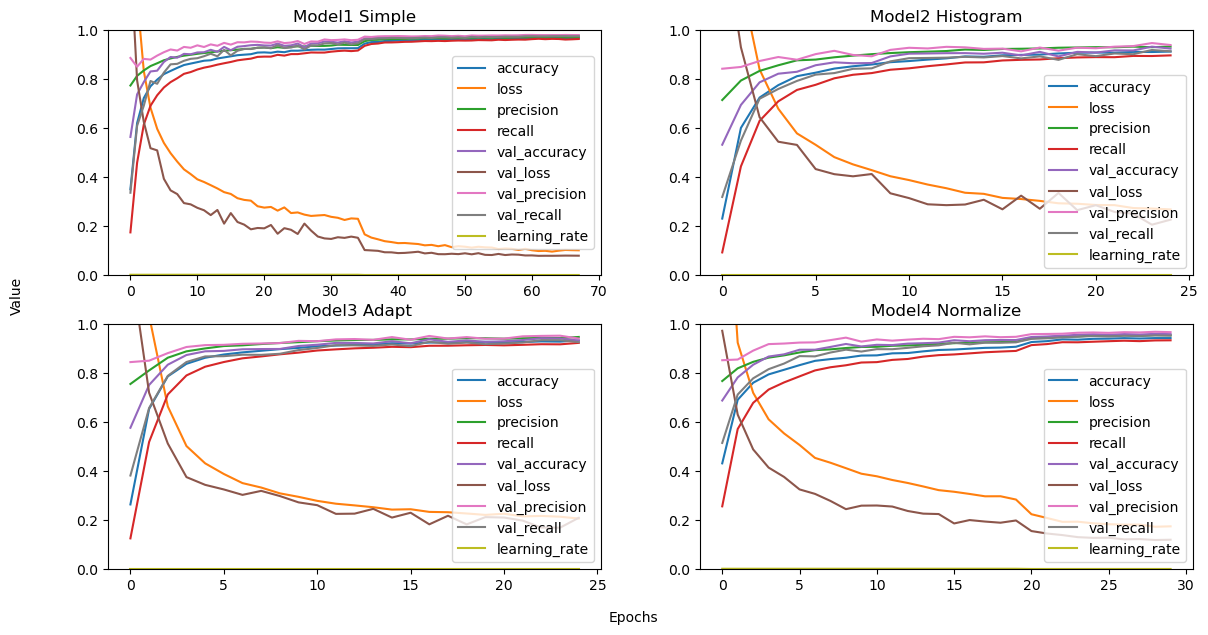

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(2, 2, figsize=(14, 7))

# Plotting history for Model1
history_keys = list(history.history.keys())
for key in history_keys:
    axes[0, 0].plot(pd.DataFrame(history.history[key]), label=key)
axes[0, 0].set_title("Model1 Simple")
axes[0, 0].set_ylim([0, 1])  # Setting y-axis limits
axes[0, 0].legend()

# Plotting history for Model2
history_histogram_keys = list(history_histogram.history.keys())
for key in history_histogram_keys:
    axes[0, 1].plot(pd.DataFrame(history_histogram.history[key]), label=key)
axes[0, 1].set_title("Model2 Histogram")
axes[0, 1].set_ylim([0, 1])  # Setting y-axis limits
axes[0, 1].legend()

# Plotting history for Model3
history_adapt_keys = list(history_adapt.history.keys())
for key in history_adapt_keys:
    axes[1, 0].plot(pd.DataFrame(history_adapt.history[key]), label=key)
axes[1, 0].set_title("Model3 Adapt")
axes[1, 0].set_ylim([0, 1])  # Setting y-axis limits
axes[1, 0].legend()

# Plotting history for Model4
history_normalize_keys = list(history_normalize.history.keys())
for key in history_normalize_keys:
    axes[1, 1].plot(pd.DataFrame(history_normalize.history[key]), label=key)
axes[1, 1].set_title("Model4 Normalize")
axes[1, 1].set_ylim([0, 1])  # Setting y-axis limits
axes[1, 1].legend()

# Adding labels to the entire figure
fig.text(0.5, 0.04, 'Epochs', ha='center', va='center')
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical')

plt.show()

In [25]:
test_data = np.array(test_data)
test_data_gray = np.array(test_data_gray)

In [26]:
test_data.shape, test_data_gray.shape

((12630, 48, 48, 3), (12630, 48, 48, 1))

In [27]:
model_preds = model.predict(test_data)
model_histogram_preds = model_histogram.predict(test_data_gray)
model_adapt_preds = model_adapt.predict(test_data_gray)
model_normalize_preds = model_normalize.predict(test_data)


395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [28]:
y_preds = np.argmax(model_preds,axis=1)
y_histogram_preds = np.argmax(model_histogram_preds,axis=1)
y_adapt_preds = np.argmax(model_adapt_preds,axis=1)
y_normalize_preds = np.argmax(model_normalize_preds,axis=1)


# Visualize the predictions

In [29]:
model_results = calculate_results(true_labels, y_preds)
model_histogram_results = calculate_results(true_labels, y_histogram_preds)
model_adapt_results = calculate_results(true_labels, y_adapt_preds)
model_normalize_results = calculate_results(true_labels, y_normalize_preds)

In [30]:
model_results, model_histogram_results, model_adapt_results, model_normalize_results

({'accuracy': 91.17181314330958,
  'precision': 0.9146455851647203,
  'recall': 0.9117181314330958,
  'f1': 0.9106929506945673},
 {'accuracy': 72.18527315914488,
  'precision': 0.7872685981030393,
  'recall': 0.7218527315914489,
  'f1': 0.7285916122568518},
 {'accuracy': 79.98416468725257,
  'precision': 0.8143489101389291,
  'recall': 0.7998416468725257,
  'f1': 0.7958257076589387},
 {'accuracy': 78.21060965954078,
  'precision': 0.8043436226391569,
  'recall': 0.7821060965954078,
  'f1': 0.7751812372161319})

Df before transpose:
            simple_model  histogram__model  adapt_model  normalize_model  \
accuracy      91.171813         72.185273    79.984165        78.210610   
precision      0.914646          0.787269     0.814349         0.804344   
recall         0.911718          0.721853     0.799842         0.782106   
f1             0.910693          0.728592     0.795826         0.775181   

           combined_results  
accuracy          90.744260  
precision          0.911533  
recall             0.907443  
f1                 0.904574  
Df after transpose:
                    accuracy  precision    recall        f1
simple_model      91.171813   0.914646  0.911718  0.910693
histogram__model  72.185273   0.787269  0.721853  0.728592
adapt_model       79.984165   0.814349  0.799842  0.795826
normalize_model   78.210610   0.804344  0.782106  0.775181
combined_results  90.744260   0.911533  0.907443  0.904574


Text(0.5, 1.0, 'Model results comparison')

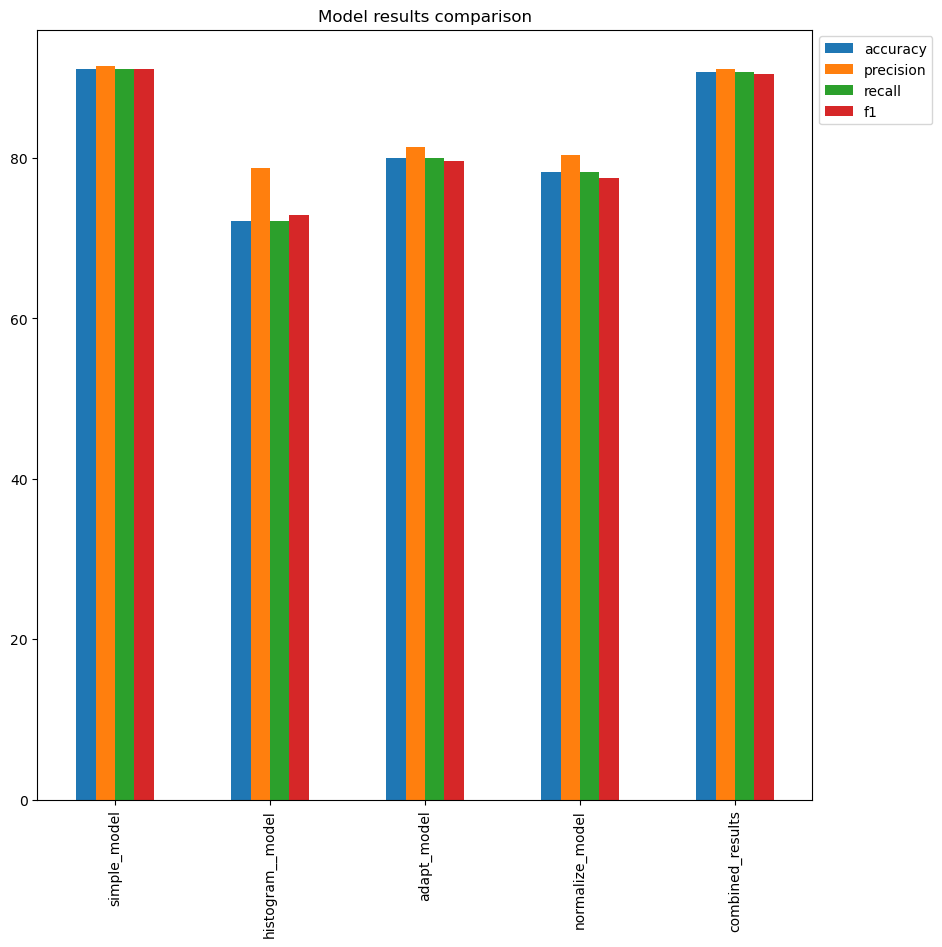

In [31]:
# Create a dictionary with all the results
all_results = {
    "simple_model":model_results,
    "histogram__model":model_histogram_results,
    "adapt_model":model_adapt_results,
    "normalize_model":model_normalize_results,
    "combined_results":final_results
}

# Transform the dictionary into a pandas dataframe
df_all_results = pd.DataFrame(all_results)
print(f"Df before transpose:\n {df_all_results}")
df_all_results = df_all_results.transpose()
print(f"Df after transpose:\n {df_all_results}")

# Plot the results
# Be careful when you copy the multiplication by 100 into a separate cell if you run this
# In a Jupyter Notebook, it will keep multiplying it by 100 indefinetly

df_all_results["precision"] = df_all_results["precision"]*100
df_all_results["recall"] = df_all_results["recall"]*100
df_all_results["f1"] = df_all_results["f1"]*100
df_all_results.plot(kind="bar", figsize=(10,10)).legend(bbox_to_anchor=(1.0,1.0))
plt.title("Model results comparison")

# Make Custom Predictions
## Out model might have problems identifying some images
### It is recommended to add image augmentation to training images in order to increase it's performance. As we can see below, it guessed 2 out of 4 images taken by myself from random google maps locations. The signs are not labeled, however, in order to see if the model was right or wrong go to train folder and see the number of the folder. If the images inside fit, like in the case of 0->folder 0 which is limit of 20km/h, the prediction is true, otherwise, it is False

In [32]:
from collections import Counter
def multi_predict(rgb_models,grayscale_models,image):
    results = []
    image = np.array(image)
    image = np.expand_dims(image,axis=0)
    for model in rgb_models:
        pred = model.predict(image)
        result = np.argmax(pred)
        results.append(result)
    
    for model in grayscale_models:
        image_rgb = tf.image.rgb_to_grayscale(image)
        pred = model.predict(image_rgb)
        result = np.argmax(pred)
        results.append(result)
    
    counter = Counter(results)
    final_answer = counter.most_common(1)[0][0]
    return final_answer

In [33]:
def load_image(path=path,rgba=False):
    """
    Load and prepare the image to predict on the model. It takes simple image,
    resizes it to (48,48), transforms it into an numpy array and expands it to be
    in shape (None,48,48,3) in order to be used by our model
    path: path to the image used
    rgba: set if the image has an alpha channel, it converts the image to rgb
    
    """
    
    loaded_image = Image.open(path)
    if rgba:
        loaded_image = loaded_image.convert("RGB")
    loaded_image = loaded_image.resize((48,48))
    loaded_image = np.array(loaded_image)
    loaded_image = np.expand_dims(loaded_image,axis=0)
    return loaded_image

In [34]:
models_gray = [model_histogram,model_adapt]
models = [model, model_normalize]

def load_and_predict_final(image,models_gray,models):
    image_gray = tf.image.rgb_to_grayscale(image)
    results = []
    for model in models:
        prediction_probs = model.predict(image)
        prediction = np.argmax(prediction_probs)
        results.append(prediction)
    for model in models_gray:
        prediction_probs = model.predict(image_gray)
        prediction = np.argmax(prediction_probs)
        results.append(prediction)
        
    counter = Counter(results)
    final_answer = counter.most_common(1)[0][0]
    return final_answer 

In [35]:
image1 = load_image("custom_image.jpg")
image2 = load_image("50_zone.jpg")
image3 = load_image("right_of_way.png", rgba=True)
image4 = load_image("stop.png",rgba=True)
image5 = load_image("danger.png",rgba=True)
image6 = load_image("give_priority.png",rgba=True)
image7 = load_image("road_priority_.png",rgba=True)



prediction1 = load_and_predict_final(image1,models_gray=models_gray,models=models)
prediction2 = load_and_predict_final(image2,models_gray=models_gray,models=models)
prediction3 = load_and_predict_final(image3,models_gray=models_gray,models=models)
prediction4 = load_and_predict_final(image4,models_gray=models_gray,models=models)
prediction5 = load_and_predict_final(image5,models_gray=models_gray,models=models)
prediction6 = load_and_predict_final(image6,models_gray=models_gray,models=models)
prediction7 = load_and_predict_final(image7,models_gray=models_gray,models=models)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━

(-0.5, 47.5, 47.5, -0.5)

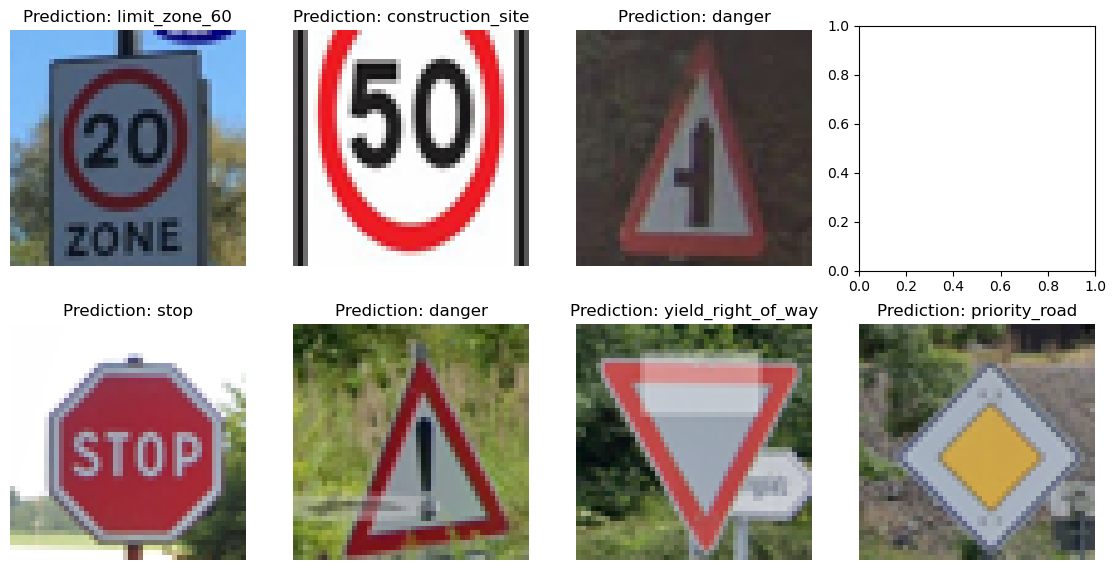

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(14,7))

axes[0,0].imshow(np.squeeze(image1))
axes[0,0].set_title(f"Prediction: {sign_names[prediction1]}")
axes[0,0].axis(False)

axes[0,1].imshow(np.squeeze(image2))
axes[0,1].set_title(f"Prediction: {sign_names[prediction2]}")
axes[0,1].axis(False)

axes[0,2].imshow(np.squeeze(image3))
axes[0,2].set_title(f"Prediction: {sign_names[prediction3]}")
axes[0,2].axis(False)


axes[1,0].imshow(np.squeeze(image4))
axes[1,0].set_title(f"Prediction: {sign_names[prediction4]}")
axes[1,0].axis(False)

axes[1,1].imshow(np.squeeze(image5))
axes[1,1].set_title(f"Prediction: {sign_names[prediction5]}")
axes[1,1].axis(False)

axes[1,2].imshow(np.squeeze(image6))
axes[1,2].set_title(f"Prediction: {sign_names[prediction6]}")
axes[1,2].axis(False)

axes[1,3].imshow(np.squeeze(image7))
axes[1,3].set_title(f"Prediction: {sign_names[prediction7]}")
axes[1,3].axis(False)

In [37]:
end_time = datetime.datetime.now()

In [38]:
time_passed = (end_time-start_time).seconds/60

In [39]:
time_passed

84.63333333333334

In [40]:
print(f"This notebook took a total of : {time_passed:.2f} minutes to execute entirely")

This notebook took a total of : 84.63 minutes to execute entirely
